In [2]:
# Import libraries
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import math
import numpy as np
import seaborn as sns
#pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

# Question 1: First Website, QS Ranking

Using Postman, we found this request which gives a JSON containing most of the data we're interested in.

In [3]:
qs_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508694016501'
qs_r = requests.get(qs_url)

In [4]:
qs_uni_dict = qs_r.json()

We create the dataframe with the column name in accordance with the data we're about to collect.

In [5]:
qs_columns = ['Name','Region','Location','QS Rank','QS Score','QS No Staffs', 'QS No International Staffs', 'QS No Students', 'QS No International Students']
qs_uni_rank = pd.DataFrame(index = [], columns=qs_columns)
qs_uni_rank.head()

,Name,Region,Location,QS Rank,QS Score,QS No Staffs,QS No International Staffs,QS No Students,QS No International Students


Since the informations about the numbers of staff and students, international or not, aren't stored in the JSON file,
we use the following function to get these data from the specific universities HTML pages.

In [6]:
def get_numbers_stud_staff(url):
    r_uni = requests.get("https://www.topuniversities.com" + url)
    
    html_request_uni = BeautifulSoup(r_uni.text, 'html.parser')
    
    header_staff = html_request_uni.find('div',class_='faculty-main wrapper col-md-4')
    header_stud_total = html_request_uni.find('div',class_='students-main wrapper col-md-4')
    header_stud_inter = html_request_uni.find('div',class_='int-students-main wrapper col-md-4')
    
    if ((header_staff == None) & (header_stud_total == None) & (header_stud_inter == None)):
        return (pd.np.nan,pd.np.nan,pd.np.nan,pd.np.nan)
        

    subdiv_staff_total = header_staff.find('div', class_='total faculty')
    subdiv_staff_inter = header_staff.find('div', class_= 'inter faculty')
    subdiv_stud_total = header_stud_total.find('div', class_='total student')
    subdiv_stud_inter = header_stud_inter.find('div', class_='total inter')
    
    num_staff_total = int(subdiv_staff_total.find('div', class_ = 'number').text[1:-1].replace(',',''))
    if (subdiv_staff_inter != None):
        num_staff_inter = int(subdiv_staff_inter.find('div', class_ = 'number').text[1:-1].replace(',',''))
    else:
        num_staff_inter = pd.np.nan
    num_stud_total = int(subdiv_stud_total.find('div', class_ = 'number').text[1:-1].replace(',',''))
    num_stud_inter = int(subdiv_stud_inter.find('div', class_ = 'number').text[1:-1].replace(',',''))
    
    return (num_staff_total, num_staff_inter, num_stud_total, num_stud_inter)

In [7]:
uni_list = qs_uni_dict['data']
i = 0
for uni in uni_list[:200]:
    i+=1
    if (i % 20 == 0):
        print("QS ranking", i / len(uni_list) * 100, "\b% scrapped")
    (tot_staff, inter_staff, tot_stud, inter_stud) = get_numbers_stud_staff(uni['url'])
    uni_df = pd.DataFrame([[uni['title'],uni['region'], uni['country'], uni['rank_display'].replace('=',' '),
                            uni['score'], tot_staff, inter_staff, tot_stud, inter_stud]], columns = qs_columns)
    qs_uni_rank = qs_uni_rank.append(uni_df)

qs_uni_rank.index = list(range(1,201))


QS ranking 2.0855057351407713% scrapped
QS ranking 4.171011470281543% scrapped
QS ranking 6.256517205422315% scrapped
QS ranking 8.342022940563085% scrapped
QS ranking 10.427528675703858% scrapped
QS ranking 12.51303441084463% scrapped
QS ranking 14.5985401459854% scrapped
QS ranking 16.68404588112617% scrapped
QS ranking 18.769551616266945% scrapped
QS ranking 20.855057351407716% scrapped


We now convert each numerical column into float type and calculate the ratios we're interested in

In [8]:
numerical_fields = list(qs_uni_rank.columns[3:]); 

#numerical_fileds = ['QS Rank', 'QS Score','QS No Staffs', 'QS No International Staffs', 'QS No Students', 'QS No International Students']

for field in numerical_fields:
    qs_uni_rank.loc[:,field] = qs_uni_rank.loc[:,field].astype(float)

qs_uni_rank['QS International Students Ratio']\
                    = qs_uni_rank['QS No International Students'] / qs_uni_rank['QS No Students']
qs_uni_rank['QS Staff per Student Ratio'] = qs_uni_rank['QS No Staffs'] / qs_uni_rank['QS No Students']

qs_uni_rank = qs_uni_rank.drop(['QS No International Students','QS No Staffs','QS No International Staffs'],axis=1)

qs_uni_rank

,Name,Region,Location,QS Rank,QS Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio
1,Massachusetts Institute of Technology (MIT),North America,United States,1.0,100.0,11067.0,0.335863,0.269450
2,Stanford University,North America,United States,2.0,98.7,15878.0,0.227422,0.269870
3,Harvard University,North America,United States,3.0,98.4,22429.0,0.234785,0.193945
4,California Institute of Technology (Caltech),North America,United States,4.0,97.7,2255.0,0.286918,0.422616
5,University of Cambridge,Europe,United Kingdom,5.0,95.6,18770.0,0.356899,0.292488
6,University of Oxford,Europe,United Kingdom,6.0,95.3,19720.0,0.372870,0.342292
7,UCL (University College London),Europe,United Kingdom,7.0,94.6,31080.0,0.477928,0.204151
8,Imperial College London,Europe,United Kingdom,8.0,93.7,16090.0,0.543567,0.244251
9,University of Chicago,North America,United States,9.0,93.5,13557.0,0.249244,0.180645
10,ETH Zurich - Swiss Federal Institute of Techno...,Europe,Switzerland,10.0,93.3,19815.0,0.381681,0.125006


In [9]:
num_values_index = ['QS International Students Ratio', 'QS Staff per Student Ratio']

region_qs = qs_uni_rank[['Region'] + num_values_index].set_index('Region')\
                .groupby('Region').mean()
    
location_qs = qs_uni_rank[['Location'] + num_values_index].set_index('Location')\
                .groupby('Location').mean()

name_qs = qs_uni_rank[['Name'] + num_values_index].set_index('Name')

Now that we grouped the values we were interested in by location, region and name, we can plot and print 
the main results

In [10]:
print( "Ten first universities in terms of international students ratio :")
print(name_qs.sort_values(['QS International Students Ratio'],ascending=False)[1:10]['QS International Students Ratio'],'\n','\n')

print( "Ten first universities in terms of staff over students ratio :")
print(name_qs.sort_values(['QS Staff per Student Ratio'],ascending=False)[1:10]['QS Staff per Student Ratio'])

Ten first universities in terms of international students ratio :
Name
Ecole Polytechnique Fédérale de Lausanne (EPFL)    0.570047
Imperial College London                            0.543567
Maastricht University                              0.502533
Carnegie Mellon University                         0.478062
UCL (University College London)                    0.477928
University of St Andrews                           0.457955
The University of Melbourne                        0.427434
Queen Mary University of London                    0.421816
The University of Hong Kong                        0.407144
Name: QS International Students Ratio, dtype: float64 
 

Ten first universities in terms of staff over students ratio :
Name
Yale University                                0.398323
University of Oxford                           0.342292
University of Cambridge                        0.292488
Johns Hopkins University                       0.276353
Stanford University                    

For the two top 10 rankings showed (proportion of international students and proportion of staffs), no university appears two times.
We can then assess than there is no correlation between these two parameters.

Ten first locations in terms of international students ratio :
Location
Australia      0.346878
Switzerland    0.313816
Hong Kong      0.312148
Austria        0.306095
Singapore      0.277091
Canada         0.252604
New Zealand    0.248971
Netherlands    0.245456
Ireland        0.241791
Name: QS International Students Ratio, dtype: float64 
 

Ten first locations in terms of staff over students ratio :
Location
Denmark          0.186580
Saudi Arabia     0.175828
Singapore        0.162279
Japan            0.155840
Malaysia         0.153893
United States    0.151151
South Korea      0.149356
France           0.144006
Israel           0.136047
Name: QS Staff per Student Ratio, dtype: float64
Number of countries represented :  34


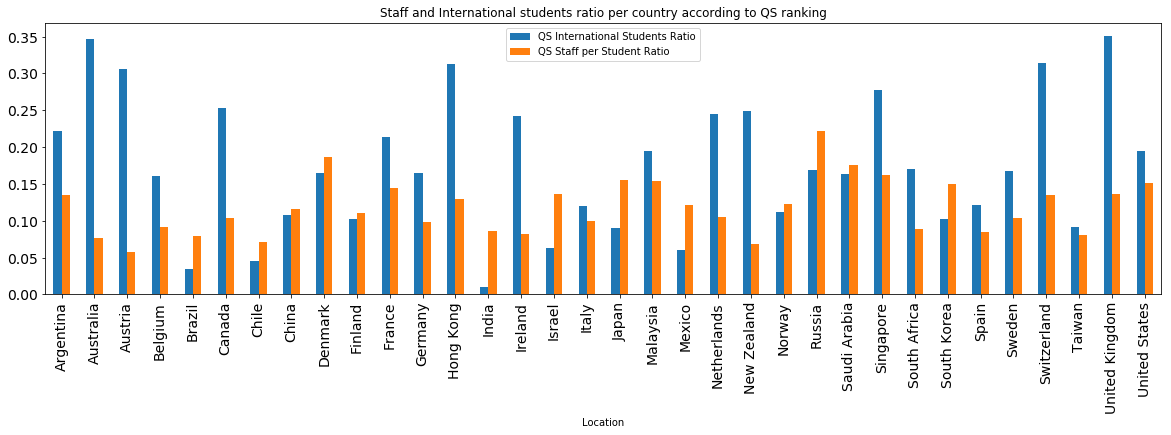

In [11]:
print( "Ten first locations in terms of international students ratio :")
print(location_qs.sort_values(['QS International Students Ratio'],ascending=False)[1:10]['QS International Students Ratio'],'\n','\n')

print( "Ten first locations in terms of staff over students ratio :")
print(location_qs.sort_values(['QS Staff per Student Ratio'],ascending=False)[1:10]['QS Staff per Student Ratio'])

location_qs.plot(kind='bar',figsize=[20,5],fontsize=14,title='Staff and International students ratio per country according to QS ranking')

print("Number of countries represented : ",location_qs.shape[0])

Only 34 countries are represented in this ranking of top universities.
For the two top 10 rankings showed, we can see that only Singapore appears in both.
There is obviously no correlation between these two parameters on a country scale, as they do not appear to be proportional on the bar chart.

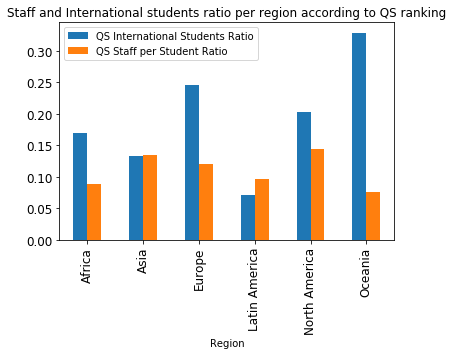

In [12]:
region_qs.plot(kind='bar',fontsize=12, title='Staff and International students ratio per region according to QS ranking')

The number of staff per student does not vary as much as the international studient ratio on a continent scale.

# Question 2: Second Website, THE ranking

Note that as the number students, the number of staffs and the number of international students are already mentionned in the QS ranking website they are not scrapped from the Times University Ranking website. We indeed assume that the information provided by the QS ranking website are reliable.

In [13]:
the_r = requests.get("https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json")

the_uni_dict = the_r.json()['data'][:200]

the_columns = ['Name','Location','THE Rank','THE Score','THE No Students', 'THE International Students Ratio','THE Staff per Student Ratio']
the_uni_rank = pd.DataFrame(index = [], columns=the_columns)
the_uni_rank.head()

,Name,Location,THE Rank,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio


In [14]:
for uni in the_uni_dict:
    uni_df = pd.DataFrame([[uni['name'],uni['location'], uni['rank'].replace('=',' '),uni['scores_overall'],\
                           uni['stats_number_students'],uni['stats_pc_intl_students'],\
                          uni['stats_student_staff_ratio']]],columns = the_columns)
    the_uni_rank = the_uni_rank.append(uni_df)
    
the_uni_rank.index = list(range(1,201))

Let's convert all the numbers in float format.

In [15]:
the_uni_rank.loc[:,'THE International Students Ratio'] = \
            the_uni_rank.loc[:,'THE International Students Ratio'].astype(str).replace({'%':''}, regex=True)\
            .astype(float)/100

numeric_fields = ['THE Rank', 'THE Score', 'THE No Students', 'THE Staff per Student Ratio']
for field in numeric_fields:
    the_uni_rank.loc[:,field] = the_uni_rank.loc[:,field].astype(str).replace({',':'.'}, regex=True).astype(float)

the_uni_rank.loc[:,'THE Staff per Student Ratio'] = 1/the_uni_rank.loc[:,'THE Staff per Student Ratio']

In [16]:
the_uni_rank.head()

,Name,Location,THE Rank,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio
1,University of Oxford,United Kingdom,1.0,94.3,20.409,0.38,0.089286
2,University of Cambridge,United Kingdom,2.0,93.2,18.389,0.35,0.091743
3,California Institute of Technology,United States,3.0,93.0,2.209,0.27,0.153846
4,Stanford University,United States,3.0,93.0,15.845,0.22,0.133333
5,Massachusetts Institute of Technology,United States,5.0,92.5,11.177,0.34,0.114943


We use the QS dataframe to get the regions since this data is not present in this dataframe. We do a merging with respect to the location to assign a region to each row.

In [17]:
qs_location_region = qs_uni_rank[['Location','Region']].drop_duplicates()

the_with_regions = pd.merge(the_uni_rank,qs_location_region, how='outer', on='Location')
qs_location_region = the_with_regions[['Location','Region']]

the_with_regions = the_with_regions[the_with_regions['THE Rank'].notnull()]
the_with_regions[the_with_regions['Region'].isnull()]

,Name,Location,THE Rank,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio,Region
196,University of Luxembourg,Luxembourg,179.0,53.8,4.969,0.57,0.068493,NaN
198,Lomonosov Moscow State University,Russian Federation,194.0,52.3,29.236,0.22,0.136986,NaN


We see that it remains two NaN values for regions, we can add it manually

In [18]:
the_with_regions.loc[the_with_regions['Location'] == 'Luxembourg','Region'] = 'Europe'
the_with_regions.loc[the_with_regions['Location'] == 'Russian Federation','Region'] = 'Europe'
the_with_regions[the_with_regions['Region'].isnull()]

,Name,Location,THE Rank,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio,Region


Now that we have a region assigned, we can do the same analysis as part 1.

In [19]:
num_values_index = ['THE International Students Ratio', 'THE Staff per Student Ratio']

region_the = the_with_regions[['Region'] + num_values_index].set_index('Region')\
                .groupby('Region').mean()
    
location_the = the_with_regions[['Location'] + num_values_index].set_index('Location')\
                .groupby('Location').mean()

name_the = the_with_regions[['Name'] + num_values_index].set_index('Name')

In [20]:
print( "THE Ten first universities in terms of international students ratio :")
print(name_the.sort_values(['THE International Students Ratio'],ascending=False)[1:10]['THE International Students Ratio'],'\n','\n')

print( "QS Ten first universities in terms of international students ratio :")
print(name_qs.sort_values(['QS International Students Ratio'],ascending=False)[1:10]['QS International Students Ratio'],'\n','\n')


print( "THE Ten first universities in terms of staff over students ratio :")
print(name_the.sort_values(['THE Staff per Student Ratio'],ascending=False)[1:10]['THE Staff per Student Ratio'],'\n\n')


print( "QS Ten first universities in terms of staff over students ratio :")
print(name_qs.sort_values(['QS Staff per Student Ratio'],ascending=False)[1:10]['QS Staff per Student Ratio'])

THE Ten first universities in terms of international students ratio :
Name
University of Luxembourg                    0.57
Imperial College London                     0.55
École Polytechnique Fédérale de Lausanne    0.55
Maastricht University                       0.50
University College London                   0.49
University of St Andrews                    0.48
Queen Mary University of London             0.45
Carnegie Mellon University                  0.45
University of Hong Kong                     0.42
Name: THE International Students Ratio, dtype: float64 
 

QS Ten first universities in terms of international students ratio :
Name
Ecole Polytechnique Fédérale de Lausanne (EPFL)    0.570047
Imperial College London                            0.543567
Maastricht University                              0.502533
Carnegie Mellon University                         0.478062
UCL (University College London)                    0.477928
University of St Andrews                           

For the proportion of international students, we find almost the same values and the same universities in the top 10 ranking.
On the other hand, the proportion of staff presents really different values and the top 10 does not contain the same universities.
The two websites have values in accordance for the international student ratio, but not for the staff ratio.

Ten first locations in terms of international students ratio :
Location
United Kingdom    0.365484
Hong Kong         0.328000
Switzerland       0.314286
Australia         0.307500
Singapore         0.305000
New Zealand       0.290000
Ireland           0.270000
Austria           0.260000
Canada            0.225000
Name: THE International Students Ratio, dtype: float64 
 

Ten first locations in terms of staff over students ratio :
Location
Italy                 0.138889
Russian Federation    0.136986
Japan                 0.132098
United States         0.106390
France                0.099352
China                 0.087420
Taiwan                0.086957
South Africa          0.085470
Switzerland           0.083447
Name: THE Staff per Student Ratio, dtype: float64
Countries represented in the THE top 200 universities :  27


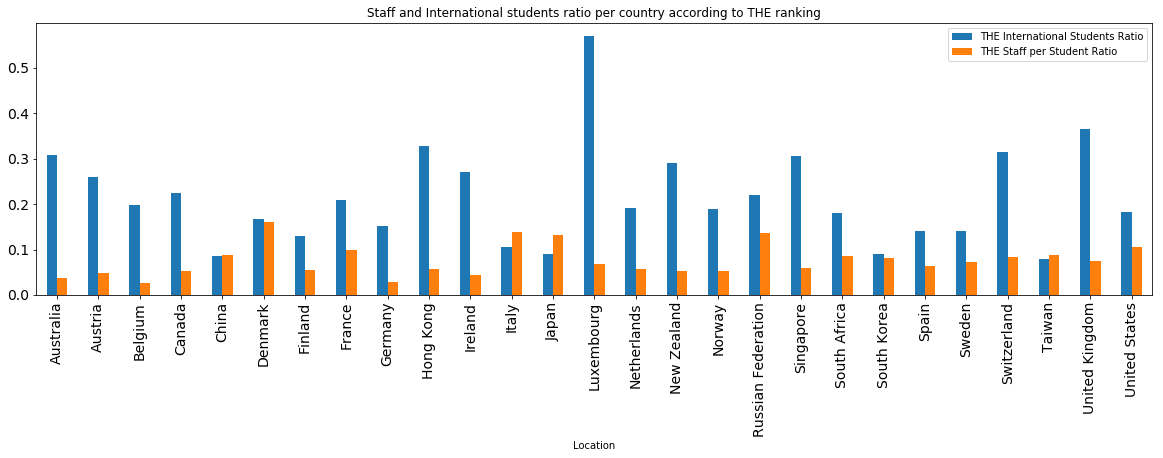

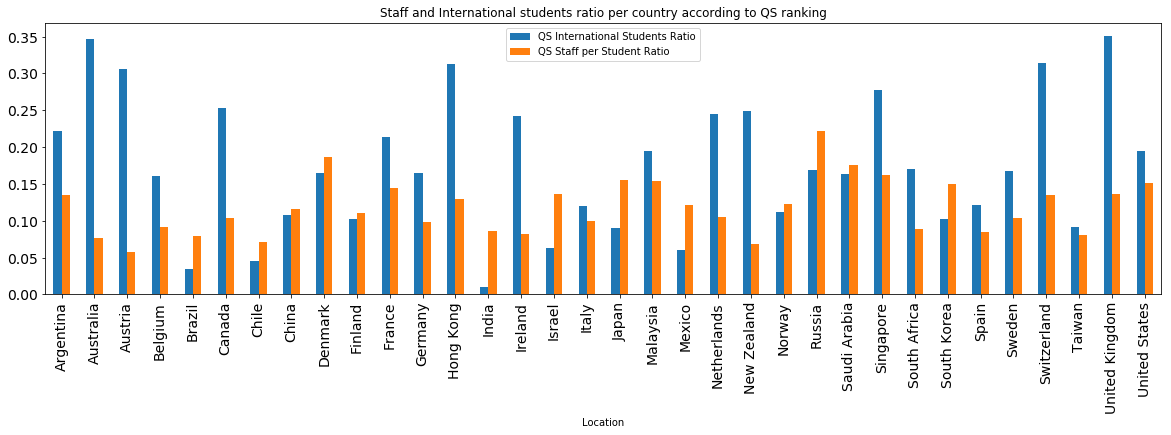

In [21]:
print( "Ten first locations in terms of international students ratio :")
print(location_the.sort_values(['THE International Students Ratio'],ascending=False)[1:10]['THE International Students Ratio'],'\n','\n')

print( "Ten first locations in terms of staff over students ratio :")
print(location_the.sort_values(['THE Staff per Student Ratio'],ascending=False)[1:10]['THE Staff per Student Ratio'])

location_the.plot(kind='bar',figsize=[20,5],fontsize=14, title='Staff and International students ratio per country according to THE ranking')
location_qs.plot(kind='bar',figsize=[20,5],fontsize=14, title='Staff and International students ratio per country according to QS ranking')

print("Countries represented in the THE top 200 universities : ", location_the.shape[0])

Only 27 countries are represented for the THE ranking, even less than in the QS ranking.
We see again that the international students values are quite the same betweend bot rankings, but the staff ratios values differ a lot. The relative values between a country compared to an other seem to be the same in each ranking.

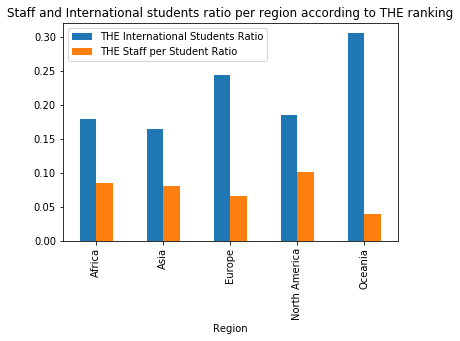

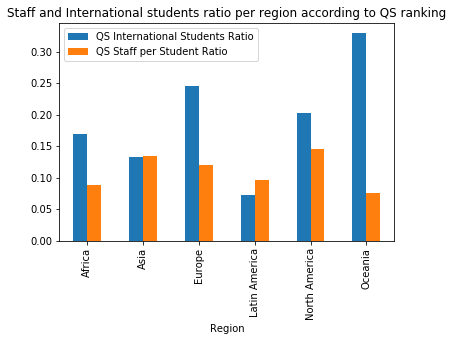

In [22]:
plt.figure()
region_the.plot(kind='bar', title='Staff and International students ratio per region according to THE ranking')
region_qs.plot(kind='bar', title='Staff and International students ratio per region according to QS ranking')

The region of Latin America is not represented in the THE ranking.
We can see again that the estimation of the staff ratio is way higher in the QS ranking.
The values still present the same tendencies in function of the regions.

In [23]:
qs_uni_rank.to_csv('qs_uni_rank.csv')
the_uni_rank.to_csv('the_uni_rank.csv')

# Question 3: Merging the two DataFrames

In [24]:
import pandas as pd
import math

In [25]:
qs_uni_rank = pd.DataFrame.from_csv('qs_uni_rank.csv')
the_uni_rank = pd.DataFrame.from_csv('the_uni_rank.csv')
qs_uni_rank.head()

,Name,Region,Location,QS Rank,QS Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio
1,Massachusetts Institute of Technology (MIT),North America,United States,1.0,100.0,11067.0,0.335863,0.269450
2,Stanford University,North America,United States,2.0,98.7,15878.0,0.227422,0.269870
3,Harvard University,North America,United States,3.0,98.4,22429.0,0.234785,0.193945
4,California Institute of Technology (Caltech),North America,United States,4.0,97.7,2255.0,0.286918,0.422616
5,University of Cambridge,Europe,United Kingdom,5.0,95.6,18770.0,0.356899,0.292488


## First filtering
In order to favor the matching of the 'Name' field between the `qs_uni_rank` and the `the_uni_rank` DataFrames the university names are modified in order to remove all special characters such as parenthesis and characters that do not belong to the English language.
#### Filtering QS data
###### Please run this cell several times until the warning disappears

In [26]:
# Removing brackets and choosing the option that is less likely to be an acronym
indices_to_change = []
content=[]
for i in range(10):
    for ind_qs, qs_uni_name in enumerate(qs_uni_rank['Name']):
        if ('(' in qs_uni_name):
            #indices_to_change += [ind_qs]
            first_brack = qs_uni_name.index('(')
            second_brack = qs_uni_name.index(')')
            brack_content = qs_uni_name[first_brack+1:second_brack]
            #print(brack_content)
            if (' ' in brack_content):
                qs_uni_rank.iloc[ind_qs, 0] = brack_content
                #content += [brack_content]
            else:
                qs_uni_rank.iloc[ind_qs, 0] = qs_uni_name[:(first_brack-1)]
                #content += [qs_uni_name[:(first_brack-1)]]
            #print(qs_uni_rank.iloc[ind_qs, 0])

        if ('é' in qs_uni_name):
            qs_uni_rank['Name'].iat[ind_qs] = qs_uni_name.replace('é','e')
        if ('ä' in qs_uni_name):
            qs_uni_rank['Name'].iat[ind_qs] = qs_uni_name.replace('ä','ae')
        if ('ü' in qs_uni_name):
            qs_uni_rank['Name'].iat[ind_qs] = qs_uni_name.replace('ü','u')
        if ('ó' in qs_uni_name):
            qs_uni_rank['Name'].iat[ind_qs] = qs_uni_name.replace('ó','o')
        if ('É' in qs_uni_name):
            qs_uni_rank['Name'].iat[ind_qs] = qs_uni_name.replace('É','E')

        if ('The ' == qs_uni_name[:4]):
            qs_uni_rank['Name'].iat[ind_qs] = qs_uni_name[4:]
#print(content)
#qs_uni_rank['Name'].iloc[indices_to_change] = pd.Series(content)

In [27]:
qs_uni_rank.head()

,Name,Region,Location,QS Rank,QS Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio
1,Massachusetts Institute of Technology,North America,United States,1.0,100.0,11067.0,0.335863,0.269450
2,Stanford University,North America,United States,2.0,98.7,15878.0,0.227422,0.269870
3,Harvard University,North America,United States,3.0,98.4,22429.0,0.234785,0.193945
4,California Institute of Technology,North America,United States,4.0,97.7,2255.0,0.286918,0.422616
5,University of Cambridge,Europe,United Kingdom,5.0,95.6,18770.0,0.356899,0.292488


#### Filtering THE data
###### Please run this cell several times until the warning disappears

In [28]:
# Removing brackets and choosing the option that is less likely to be an acronym
for i in range(10):
    for ind_the, the_uni_name in enumerate(the_uni_rank['Name']):
        if ('(' in the_uni_name):
            first_brack = the_uni_name.index('(')
            second_brack = the_uni_name.index(')')
            brack_content = the_uni_name[first_brack+1:second_brack]

            if (' ' in brack_content):
                the_uni_rank['Name'].iat[ind_the] = brack_content
            else:
                the_uni_rank['Name'].iat[ind_the] = the_uni_name[:first_brack-1]

        if ('é' in the_uni_name):
            the_uni_rank['Name'].iat[ind_the] = the_uni_name.replace('é','e')
        if ('ä' in the_uni_name):
            the_uni_rank['Name'].iat[ind_the] = the_uni_name.replace('ä','ae')
        if ('ü' in the_uni_name):
            the_uni_rank['Name'].iat[ind_the] = the_uni_name.replace('ü','u')
        if ('ó' in the_uni_name):
            the_uni_rank['Name'].iat[ind_the] = the_uni_name.replace('ó','o')
        if ('É' in the_uni_name):
            the_uni_rank['Name'].iat[ind_the] = the_uni_name.replace('É','E')
        if ('’' in the_uni_name):
            the_uni_rank['Name'].iat[ind_the] = the_uni_name.replace('’','\'')
        if ('–' in the_uni_name):
            the_uni_rank['Name'].iat[ind_the] = the_uni_name.replace('–', '-')


In [29]:
the_uni_rank.head()

,Name,Location,THE Rank,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio
1,University of Oxford,United Kingdom,1.0,94.3,20.409,0.38,0.089286
2,University of Cambridge,United Kingdom,2.0,93.2,18.389,0.35,0.091743
3,California Institute of Technology,United States,3.0,93.0,2.209,0.27,0.153846
4,Stanford University,United States,3.0,93.0,15.845,0.22,0.133333
5,Massachusetts Institute of Technology,United States,5.0,92.5,11.177,0.34,0.114943


###### Resolving Location field conflict
There is an entry in both DataFrames whose 'Name' field match but not the 'Location' field. It is important to correct it because it would prevent the merge operation to work well. It actually concerns the university 'Lomonosov Moscow State University'. This divergence is corrected in the cell below.

In [30]:
print("Before changing:")
print(qs_uni_rank[qs_uni_rank['Name'] == 'Lomonosov Moscow State University']['Location'])
print(the_uni_rank[the_uni_rank['Name'] == 'Lomonosov Moscow State University']['Location'])
the_uni_rank.loc[194, 'Location'] = 'Russia'
print()
print("After changing:")
print(the_uni_rank[the_uni_rank['Name'] == 'Lomonosov Moscow State University']['Location'])


Before changing:
95    Russia
Name: Location, dtype: object
194    Russian Federation
Name: Location, dtype: object

After changing:
194    Russia
Name: Location, dtype: object


###### First merge 
Now we merge the `qs_uni_rank` and the `the_uni_rank` DataFrames. Only the university names that perfectly match between both DataFrames will perfectly merge, filling all the column fields. The university names that didn't find a counterpart will only have valid values in the column fields that are related to the ranking they belong to.

In [31]:
first_merged_uni_rank = pd.merge(qs_uni_rank, the_uni_rank, how = "outer")
first_merged_uni_rank.head()

,Name,Region,Location,QS Rank,QS Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio,THE Rank,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio
0,Massachusetts Institute of Technology,North America,United States,1.0,100.0,11067.0,0.335863,0.269450,5.0,92.5,11.177,0.34,0.114943
1,Stanford University,North America,United States,2.0,98.7,15878.0,0.227422,0.269870,3.0,93.0,15.845,0.22,0.133333
2,Harvard University,North America,United States,3.0,98.4,22429.0,0.234785,0.193945,6.0,91.8,20.326,0.26,0.112360
3,California Institute of Technology,North America,United States,4.0,97.7,2255.0,0.286918,0.422616,3.0,93.0,2.209,0.27,0.153846
4,University of Cambridge,Europe,United Kingdom,5.0,95.6,18770.0,0.356899,0.292488,2.0,93.2,18.389,0.35,0.091743


## Second filtering
We construct two new DataFrames for the universities that didn't match by name during the first filtering. These two DataFrames are named `qs_unmatched` and `the_unmatched` respectively for the universities of the QS ranking and of the THE ranking that didn't match by name any counter part. Then we create a new DataFrame for the universities that perfectly matched by name which is called ´perfect_match_merged´.

In [32]:
qs_unmatched = first_merged_uni_rank[first_merged_uni_rank['THE No Students'].isnull()].copy()
the_unmatched = first_merged_uni_rank[first_merged_uni_rank['QS No Students'].isnull()].copy()
perfect_match_merged_bis = first_merged_uni_rank[first_merged_uni_rank['THE No Students'].notnull()].copy()
perfect_match_merged = perfect_match_merged_bis[perfect_match_merged_bis['QS No Students'].notnull()].copy()

Below you can see extracts of the three DataFrames that have just been created.

In [33]:
qs_unmatched.head()

,Name,Region,Location,QS Rank,QS Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio,THE Rank,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio
9,ETH Zurich - Swiss Federal Institute of Techno...,Europe,Switzerland,10.0,93.3,19815.0,0.381681,0.125006,NaN,NaN,NaN,NaN,NaN
40,KAIST - Korea Advanced Institute of Science & ...,Asia,South Korea,41.0,80.4,9826.0,0.059434,0.127214,NaN,NaN,NaN,NaN,NaN
42,"Ecole normale superieure, Paris",Europe,France,43.0,79.9,1907.0,0.196120,0.093340,NaN,NaN,NaN,NaN,NaN
44,UNSW Sydney,Oceania,Australia,45.0,78.9,39784.0,0.359240,0.073497,NaN,NaN,NaN,NaN,NaN
55,Tokyo Institute of Technology,Asia,Japan,56.0,74.8,9832.0,0.108930,0.158971,NaN,NaN,NaN,NaN,NaN


In [34]:
the_unmatched.head()

,Name,Region,Location,QS Rank,QS Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio,THE Rank,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio
51,New York University,North America,United States,52.0,77.3,NaN,NaN,NaN,27.0,79.2,43.860,0.26,0.104167
200,ETH Zurich - Swiss Federal Institute of Techno...,NaN,Switzerland,NaN,NaN,NaN,NaN,NaN,10.0,87.7,19.233,0.38,0.068493
201,LMU Munich,NaN,Germany,NaN,NaN,NaN,NaN,NaN,34.0,76.2,36.091,0.15,0.064103
202,Karolinska Institute,NaN,Sweden,NaN,NaN,NaN,NaN,NaN,38.0,75.3,7.424,0.19,0.091743
203,Heidelberg University,NaN,Germany,NaN,NaN,NaN,NaN,NaN,45.0,72.3,28.876,0.17,0.043103


In [35]:
perfect_match_merged.head()

,Name,Region,Location,QS Rank,QS Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio,THE Rank,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio
0,Massachusetts Institute of Technology,North America,United States,1.0,100.0,11067.0,0.335863,0.269450,5.0,92.5,11.177,0.34,0.114943
1,Stanford University,North America,United States,2.0,98.7,15878.0,0.227422,0.269870,3.0,93.0,15.845,0.22,0.133333
2,Harvard University,North America,United States,3.0,98.4,22429.0,0.234785,0.193945,6.0,91.8,20.326,0.26,0.112360
3,California Institute of Technology,North America,United States,4.0,97.7,2255.0,0.286918,0.422616,3.0,93.0,2.209,0.27,0.153846
4,University of Cambridge,Europe,United Kingdom,5.0,95.6,18770.0,0.356899,0.292488,2.0,93.2,18.389,0.35,0.091743


In [36]:
qs_unmatched.shape

(61, 13)

In [37]:
the_unmatched.shape

(62, 13)

The universtity names that didn't match are printed below

###### Collecting unmatched university names
The university names that didn't match are collected below and stored in ´names_qs_unmatched´ and ´names_the_unmatched´ respectively for the QS ranking and the THE ranking. Theses lists are then going to be filtered in order to remove their stop words. This way they will be more easily comparable.

In [38]:
names_qs_unmatched = [qs_unmatched['Name'].iloc[x] for x in range(qs_unmatched.shape[0])]
names_the_unmatched = [the_unmatched['Name'].iloc[x] for x in range(the_unmatched.shape[0])]

In [39]:
print(names_qs_unmatched)
print()
print(names_the_unmatched)

['ETH Zurich - Swiss Federal Institute of Technology', 'KAIST - Korea Advanced Institute of Science & Technology', 'Ecole normale superieure, Paris', 'UNSW Sydney', 'Tokyo Institute of Technology', 'Osaka University', 'Ludwig-Maximilians-Universitaet Munchen', 'Ruprecht-Karls-Universitaet Heidelberg', 'Pohang University of Science And Technology', 'Universidad de Buenos Aires', 'Tohoku University', 'University of North Carolina, Chapel Hill', 'Trinity College Dublin, The University of Dublin', 'Korea University', 'Washington University in St. Louis', 'Yonsei University', 'KIT, Karlsruhe Institute of Technology', 'Universiti Malaya', 'Nagoya University', 'Humboldt-Universitaet zu Berlin', 'Universidade de São Paulo', 'Universidad Nacional Autonoma de Mexico ', 'Hokkaido University', 'Wageningen University', 'Freie Universitaet Berlin', 'Kyushu University', 'Universite de Montreal', 'Universite Pierre et Marie Curie', 'Chalmers University of Technology', 'Pontificia Universidad Catolica 

###### Removing of stop words
Below is defined the dictionnary of words and characters that are considered as stop words. They are removed from both university names list thanks to the ´remove_stop_word´ function defined below.

In [40]:
stop_words_repo = [' & ', ' de ', ' of ', ',', ' di ', '-', '\'', ' and ', ' And ', '.', ' zu ', ' at ', ' et ']

In [41]:
def remove_stop_words(string, stop_words_repo):
    for stop_word in stop_words_repo:
        while (stop_word in string):
            index = string.find(stop_word)            
            string = string[:index] + string[(index + len(stop_word)):]
    return string

In [42]:
remove_stop_words('University de Lausanne', stop_words_repo)

'UniversityLausanne'

Removing of stop wors for the QS unmatched university names.

In [43]:
for i, name in enumerate(names_qs_unmatched):
    new_name = remove_stop_words(name, stop_words_repo)
    # remove spaces
    new_name = remove_stop_words(new_name, ' ')
    names_qs_unmatched[i] = new_name
print(names_qs_unmatched)

['ETHZurichSwissFederalInstituteTechnology', 'KAISTKoreaAdvancedInstituteScienceTechnology', 'EcolenormalesuperieureParis', 'UNSWSydney', 'TokyoInstituteTechnology', 'OsakaUniversity', 'LudwigMaximiliansUniversitaetMunchen', 'RuprechtKarlsUniversitaetHeidelberg', 'PohangUniversityScienceTechnology', 'UniversidadBuenosAires', 'TohokuUniversity', 'UniversityNorthCarolinaChapelHill', 'TrinityCollegeDublinTheUniversityDublin', 'KoreaUniversity', 'WashingtonUniversityinStLouis', 'YonseiUniversity', 'KITKarlsruheInstituteTechnology', 'UniversitiMalaya', 'NagoyaUniversity', 'HumboldtUniversitaetBerlin', 'UniversidadeSãoPaulo', 'UniversidadNacionalAutonomaMexico', 'HokkaidoUniversity', 'WageningenUniversity', 'FreieUniversitaetBerlin', 'KyushuUniversity', 'UniversiteMontreal', 'UniversitePierreMarieCurie', 'ChalmersUniversityTechnology', 'PontificiaUniversidadCatolicaChile', 'TUBerlin', 'HebrewUniversityJerusalem', 'UniversityOtago', 'UniversityWaterloo', 'UniversitecatholiqueLouvain', 'Hanyan

Removing of stop wors for the THE unmatched university names.

In [44]:
for i, name in enumerate(names_the_unmatched):
    new_name = remove_stop_words(name, stop_words_repo)
    # remove spaces
    new_name = remove_stop_words(new_name, ' ')
    names_the_unmatched[i] = new_name
print(names_the_unmatched)

['NewYorkUniversity', 'ETHZurichSwissFederalInstituteTechnologyZurich', 'LMUMunich', 'KarolinskaInstitute', 'HeidelbergUniversity', 'WashingtonUniversityinStLouis', 'UniversityNorthCarolinaChapelHill', 'HumboldtUniversityBerlin', 'WageningenUniversityResearch', 'ParisSciencesLettresPSLResearchUniversityParis', 'UniversityFreiburg', 'UniversityNewSouthWales', 'FreeUniversityBerlin', 'TechnicalUniversityBerlin', 'UniversityTubingen', 'KoreaAdvancedInstituteScienceTechnology', 'UniversityBonn', 'VanderbiltUniversity', 'UniversityMontreal', 'IndianaUniversity', 'TrinityCollegeDublin', 'RadboudUniversityNijmegen', 'GeorgetownUniversity', 'PierreMarieCurieUniversity', 'UniversityMannheim', 'ArizonaStateUniversity', 'ChariteUniversitaetsmedizinBerlin', 'UniversiteCatholiqueLouvain', 'KarlsruheInstituteTechnology', 'PohangUniversityScienceTechnology', 'PompeuFabraUniversity', 'UniversityCologne', 'AutonomousUniversityBarcelona', 'UniversitySussex', 'UniversityNotreDame', 'ScuolaSuperioreSantAn

###### Perfect match check after stop words filtering
We now compare the university names without their stop words and we check if there is any perfect match.

In [45]:
count = 0
qs_matches = []
the_matches = []
for ind_the, name_the in enumerate(names_the_unmatched):
    true_the_name = the_unmatched['Name'].iloc[ind_the]
    for ind_qs, name_qs in enumerate(names_qs_unmatched):
        if (name_qs == name_the):
            count+=1
            true_qs_name = qs_unmatched['Name'].iloc[ind_qs]
            try:
                the_unmatched['Name'].iloc[ind_the] = true_qs_name
            except SettingWithCopyWarning:
                print("catched")
            qs_matches+=[ind_qs]
            the_matches+=[ind_the]
            print(true_the_name, "changed to", true_qs_name, ind_the)
print("Number of university names changed:", count)


Washington University in St Louis changed to Washington University in St. Louis 5
University of North Carolina at Chapel Hill changed to University of North Carolina, Chapel Hill 6
Pohang University of Science and Technology changed to Pohang University of Science And Technology 29
Number of university names changed: 3


/home/adrien/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Now that we have identified the rows in both DataFrames that matches perfectly we 

In [46]:
qs_columns = qs_uni_rank.columns
the_columns = the_uni_rank.columns

In [47]:
new_df_to_append = pd.merge(the_unmatched[the_columns].iloc[the_matches].copy(),\
                            qs_unmatched[qs_columns].iloc[qs_matches].copy())
perfect_match_merged = perfect_match_merged.append(new_df_to_append)

In [48]:
perfect_match_merged.tail()

,Location,Name,QS International Students Ratio,QS No Students,QS Rank,QS Score,QS Staff per Student Ratio,Region,THE International Students Ratio,THE No Students,THE Rank,THE Score,THE Staff per Student Ratio
196,United States,Texas A&M University,0.081268,60294.0,195.0,48.1,0.057153,North America,0.09,56.245,159.0,55.0,0.042373
198,Netherlands,Maastricht University,0.502533,16385.0,200.0,47.9,0.077937,Europe,0.50,16.727,103.0,60.4,0.055556
0,United States,Washington University in St. Louis,0.200831,13474.0,100.0,64.6,0.200312,North America,0.17,12.600,50.0,70.8,0.133333
1,United States,"University of North Carolina, Chapel Hill",0.076223,25373.0,80.0,67.8,0.160919,North America,0.08,34.684,56.0,69.0,0.103093
2,South Korea,Pohang University of Science And Technology,0.040423,3117.0,71.0,69.4,0.213025,Asia,0.04,3.046,137.0,57.3,0.096154


We drop the indices of the university names that matched in the two string lists that we are maintaining.

In [49]:
names_qs_unmatched = [names_qs_unmatched[x] for x in range(len(names_qs_unmatched)) if x not in qs_matches]
names_the_unmatched = [names_the_unmatched[x] for x in range(len(names_the_unmatched)) if x not in the_matches]

We now drop the rows that matched from the two DataFrames of unmatched university names that we are maintaining.

In [50]:
qs_unmatched = qs_unmatched.drop(qs_unmatched.index[qs_matches])
the_unmatched = the_unmatched.drop(the_unmatched.index[the_matches])

### Levenshtein distance computation
We actually end up with only one new match but we are going to use these lists of filtered names in the following.
Firstly we define the ´levenshtein_distance´ function which computes the levenshtein distance between two strings. See https://www.wikiwand.com/en/Levenshtein_distance for more details about this metrics.

In [51]:
def levenshtein_distance(string1, string2):
    rows = len(string1)+1
    cols = len(string2)+1
    dist = [[0 for x in range(cols)] for x in range(rows)]

    for i in range(1, rows):
        dist[i][0] = i
    # target prefixes can be created from an empty source string
    # by inserting the characters
    for i in range(1, cols):
        dist[0][i] = i
        
    for col in range(1, cols):
        for row in range(1, rows):
            if string1[row-1] == string2[col-1]:
                cost = 0
            else:
                cost = 1
            dist[row][col] = min(dist[row-1][col] + 1, dist[row][col-1] + 1, dist[row-1][col-1] + cost)
 
    return dist[row][col]

###### Matches for Levenshtein distance less than 5
Below we try to find the universities in the unmatched ones that have the smallest Levenshtein distance between each others. We print each change that have been made and we store them in an array to be sure that no university name change have been made mistakenly. To avoid unconsistent matches we set a cut_off of 5. This way it prevents universities whose names are too different from matching.

In [52]:
changes=[]
matched_qs=[]
matched_the=[]
cut_off = 5
for ind_the, name_the in enumerate(names_the_unmatched):
    min_dist = math.inf
    flag = False
    true_the_name = the_unmatched['Name'].iloc[ind_the]
    for ind_qs, name_qs in enumerate(names_qs_unmatched):
        lev_dist = levenshtein_distance(name_qs, name_the)
        if (lev_dist < min_dist and lev_dist < 5):
            flag = True
            best_qs = ind_qs
            true_qs_name = qs_unmatched['Name'].iloc[ind_qs]
            min_dist = lev_dist
            #the_unmatched['Name'].loc[ind_the] = true_qs_name
    if (flag == True):
        matched_qs += [best_qs]
        matched_the += [ind_the]
        #print(true_the_name, 'with', true_qs_name)
        changes += [[(ind_the, true_the_name), (best_qs, true_qs_name)]]
changes

[[(5, 'Humboldt University of Berlin'),
  (16, 'Humboldt-Universitaet zu Berlin')],
 [(10, 'Free University of Berlin'), (21, 'Freie Universitaet Berlin')],
 [(14, 'University of Bonn'), (34, 'University of Bath')],
 [(16, 'University of Montreal'), (23, 'Universite de Montreal')],
 [(25, 'Universite Catholique de Louvain'),
  (31, 'Universite catholique de Louvain')],
 [(26, 'Karlsruhe Institute of Technology'),
  (13, 'KIT, Karlsruhe Institute of Technology')],
 [(49, 'University of Miami'), (29, 'University of Otago')]]

Now we have a list of all the matches proposed when going through the previous loop. The idea then is to identify by hand the proposed matches that are relevant and those that are not. Finally for the matches that are relevant the THE university name is set to the QS university name. This way we will be able to merge the universities concerned by the match and we will then be able to append the new matched rows to the `perfect_match_merged` DataFrame.

Note that this process of compting the Levenshtein distance to compare the different university names is very useful to identify the stop words that differentiate the two name versions of a same university. Thus iteratively we add the stop words to the ´stop_words_repo´ instantiated a short time ago.

In [53]:
indices_the_matched = [5, 10, 16, 25, 26]
indices_qs_matched = [16, 21, 23, 31, 13]

new_the_names = qs_unmatched['Name'].iloc[indices_qs_matched]
for i, name in enumerate(new_the_names):
    the_unmatched['Name'].iloc[indices_the_matched[i]] = name

/home/adrien/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Now we merge the rows of ´qs_unmatched´ and ´the_unmatched´ DataFrames that matched and we append the merged DataFrame to the ´perfect_match_merged´ one.

In [54]:
new_df = pd.merge(qs_unmatched[qs_columns].iloc[indices_qs_matched].copy(),\
                  the_unmatched[the_columns].iloc[indices_the_matched].copy(), how="outer")
perfect_match_merged = perfect_match_merged.append(new_df)

In [55]:
the_unmatched = the_unmatched.drop(the_unmatched.index[indices_the_matched])
qs_unmatched = qs_unmatched.drop(qs_unmatched.index[indices_qs_matched])

names_the_unmatched = [names_the_unmatched[x] for x in range(len(names_the_unmatched)) if x not in indices_the_matched]
names_qs_unmatched = [names_qs_unmatched[x] for x in range(len(names_qs_unmatched)) if x not in indices_qs_matched]

Now we update the rows that matched. First we set the THE university names that matched to their counterpart university name in the QS unmatched DataFrame. And then we merge those lines together and we append them to the perfect_match_merged DataFrame.

###### Matches for Levenshtein distance less than 6
Now we are going to do the procedure again but with a cut_off of 6 for the Levenshtein distance.

In [56]:
changes = []
cut_off = 6
for ind_the, name_the in enumerate(names_the_unmatched):
    min_dist = math.inf
    flag = False
    true_the_name = the_unmatched['Name'].iloc[ind_the]
    for ind_qs, name_qs in enumerate(names_qs_unmatched):
        lev_dist = levenshtein_distance(name_qs, name_the)
        if (lev_dist < min_dist and lev_dist < cut_off):
            flag = True
            best_qs = ind_qs
            true_qs_name = qs_unmatched['Name'].iloc[ind_qs]
            min_dist = lev_dist
            #the_unmatched['Name'].loc[ind_the] = true_qs_name
    if (flag == True):
        matched_qs += [best_qs]
        matched_the += [ind_the]
        #print(true_the_name, 'with', true_qs_name)
        changes += [[(ind_the, true_the_name), (best_qs, true_qs_name)]]
changes

[[(0, 'New York University'), (14, 'Nagoya University')],
 [(10, 'University of Tubingen'), (31, 'University of Bergen')],
 [(11, 'Korea Advanced Institute of Science and Technology'),
  (1, 'KAIST - Korea Advanced Institute of Science & Technology')],
 [(12, 'University of Bonn'), (29, 'University of Bath')],
 [(14, 'Indiana University'), (5, 'Osaka University')],
 [(25, 'University of Sussex'), (31, 'University of Bergen')],
 [(28, 'TU Dresden'), (23, 'TU Berlin')],
 [(29, 'Ulm University'), (5, 'Osaka University')],
 [(38, 'Tufts University'), (5, 'Osaka University')],
 [(44, 'University of Miami'), (25, 'University of Otago')],
 [(45, 'University of Dundee'), (31, 'University of Bergen')]]

In [57]:
indices_the_matched = [11]
indices_qs_matched = [1]

new_the_names = qs_unmatched['Name'].iloc[indices_qs_matched]
for i, name in enumerate(new_the_names):
    the_unmatched['Name'].iloc[indices_the_matched[i]] = name


/home/adrien/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Now we merge the rows of `qs_unmatched` and `the_unmatched` DataFrames that matched and we append the merged DataFrame to the `perfect_match_merged` one.

In [58]:
new_df = pd.merge(qs_unmatched[qs_columns].iloc[indices_qs_matched].copy(),\
                  the_unmatched[the_columns].iloc[indices_the_matched].copy(), how="outer")
perfect_match_merged = perfect_match_merged.append(new_df)

In [59]:
the_unmatched = the_unmatched.drop(the_unmatched.index[indices_the_matched])
qs_unmatched = qs_unmatched.drop(qs_unmatched.index[indices_qs_matched])

names_the_unmatched = [names_the_unmatched[x] for x in range(len(names_the_unmatched)) if x not in indices_the_matched]
names_qs_unmatched = [names_qs_unmatched[x] for x in range(len(names_qs_unmatched)) if x not in indices_qs_matched]

###### Matches for Levenshtein distance less than 7
Now we are going to do the procedure again but with a cut_off of 6 for the Levenshtein distance.

In [60]:
changes = []
cut_off = 7
for ind_the, name_the in enumerate(names_the_unmatched):
    min_dist = math.inf
    flag = False
    true_the_name = the_unmatched['Name'].iloc[ind_the]
    for ind_qs, name_qs in enumerate(names_qs_unmatched):
        lev_dist = levenshtein_distance(name_qs, name_the)
        if (lev_dist < min_dist and lev_dist < cut_off):
            flag = True
            best_qs = ind_qs
            true_qs_name = qs_unmatched['Name'].iloc[ind_qs]
            min_dist = lev_dist
            #the_unmatched['Name'].loc[ind_the] = true_qs_name
    if (flag == True):
        matched_qs += [best_qs]
        matched_the += [ind_the]
        #print(true_the_name, 'with', true_qs_name)
        changes += [[(ind_the, true_the_name), (best_qs, true_qs_name)]]
changes

[[(0, 'New York University'), (13, 'Nagoya University')],
 [(1, 'ETH Zurich - Swiss Federal Institute of Technology Zurich'),
  (0, 'ETH Zurich - Swiss Federal Institute of Technology')],
 [(7, 'University of Freiburg'), (45, 'University of Reading')],
 [(10, 'University of Tubingen'), (30, 'University of Bergen')],
 [(11, 'University of Bonn'), (28, 'University of Bath')],
 [(13, 'Indiana University'), (4, 'Osaka University')],
 [(14, 'Trinity College Dublin'), (32, 'University College Dublin')],
 [(18, 'University of Mannheim'), (28, 'University of Bath')],
 [(22, 'University of Cologne'), (24, 'University of Otago')],
 [(24, 'University of Sussex'), (30, 'University of Bergen')],
 [(27, 'TU Dresden'), (22, 'TU Berlin')],
 [(28, 'Ulm University'), (4, 'Osaka University')],
 [(31, 'University of Arizona'), (24, 'University of Otago')],
 [(37, 'Tufts University'), (4, 'Osaka University')],
 [(39, 'University of Munster'), (28, 'University of Bath')],
 [(42, 'Paris-Sud University'), (18

In [61]:
indices_the_matched = [1, 14]
indices_qs_matched = [0, 32]

new_the_names = qs_unmatched['Name'].iloc[indices_qs_matched]
for i, name in enumerate(new_the_names):
    the_unmatched['Name'].iloc[indices_the_matched[i]] = name

/home/adrien/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Now we merge the rows of `qs_unmatched` and `the_unmatched` DataFrames that matched and we append the merged DataFrame to the `perfect_match_merged` one.

In [62]:
new_df = pd.merge(qs_unmatched[qs_columns].iloc[indices_qs_matched].copy(),\
                  the_unmatched[the_columns].iloc[indices_the_matched].copy(), how="outer")
perfect_match_merged = perfect_match_merged.append(new_df)

In [63]:
the_unmatched = the_unmatched.drop(the_unmatched.index[indices_the_matched])
qs_unmatched = qs_unmatched.drop(qs_unmatched.index[indices_qs_matched])

names_the_unmatched = [names_the_unmatched[x] for x in range(len(names_the_unmatched)) if x not in indices_the_matched]
names_qs_unmatched = [names_qs_unmatched[x] for x in range(len(names_qs_unmatched)) if x not in indices_qs_matched]

###### Matches for Levenshtein distance less than 8
Now we are going to do the procedure again but with a cut_off of 8 for the Levenshtein distance.

In [64]:
changes = []
cut_off = 8
for ind_the, name_the in enumerate(names_the_unmatched):
    min_dist = math.inf
    flag = False
    true_the_name = the_unmatched['Name'].iloc[ind_the]
    for ind_qs, name_qs in enumerate(names_qs_unmatched):
        lev_dist = levenshtein_distance(name_qs, name_the)
        if (lev_dist < min_dist and lev_dist < cut_off):
            flag = True
            best_qs = ind_qs
            true_qs_name = qs_unmatched['Name'].iloc[ind_qs]
            min_dist = lev_dist
            #the_unmatched['Name'].loc[ind_the] = true_qs_name
    if (flag == True):
        matched_qs += [best_qs]
        matched_the += [ind_the]
        #print(true_the_name, 'with', true_qs_name)
        changes += [[(ind_the, true_the_name), (best_qs, true_qs_name)]]
changes

[[(0, 'New York University'), (12, 'Nagoya University')],
 [(6, 'University of Freiburg'), (43, 'University of Reading')],
 [(9, 'University of Tubingen'), (29, 'University of Bergen')],
 [(10, 'University of Bonn'), (27, 'University of Bath')],
 [(11, 'Vanderbilt University'), (10, 'Yonsei University')],
 [(12, 'Indiana University'), (3, 'Osaka University')],
 [(14, 'Georgetown University'), (9, 'Korea University')],
 [(16, 'University of Mannheim'), (27, 'University of Bath')],
 [(20, 'University of Cologne'), (23, 'University of Otago')],
 [(22, 'University of Sussex'), (29, 'University of Bergen')],
 [(23, 'University of Notre Dame'), (23, 'University of Otago')],
 [(25, 'TU Dresden'), (21, 'TU Berlin')],
 [(26, 'Ulm University'), (3, 'Osaka University')],
 [(28, 'University of Leicester'), (29, 'University of Bergen')],
 [(29, 'University of Arizona'), (23, 'University of Otago')],
 [(33, 'University of Wurzburg'), (24, 'University of Waterloo')],
 [(35, 'Tufts University'), (3, '

We don't have any matches any longer so we are just going to assume that all the remaining universities in the two DataFrames of unmatched universities are just universities that are in only one of the two rankings. Therefore all these extra universities will be added to the general DataFrame that we are growing.

In [65]:
perfect_match_merged.tail(20)

,Location,Name,QS International Students Ratio,QS No Students,QS Rank,QS Score,QS Staff per Student Ratio,Region,THE International Students Ratio,THE No Students,THE Rank,THE Score,THE Staff per Student Ratio
179,Netherlands,University of Twente,0.239498,9332.0,179.0,49.7,0.097514,Europe,0.27,6.697,179.0,53.8,0.078125
180,Germany,University of Göttingen,0.122887,30402.0,181.0,49.6,0.120979,Europe,0.12,28.554,113.0,59.2,0.035842
183,United States,University of Colorado Boulder,0.088653,30219.0,182.0,49.5,0.121943,North America,0.10,30.780,100.0,60.5,0.061350
185,United States,University of Rochester,0.291096,9636.0,186.0,49.3,0.266604,North America,0.29,9.636,153.0,55.6,0.232558
190,South Africa,University of Cape Town,0.169703,19593.0,191.0,48.9,0.088450,Africa,0.18,20.775,171.0,54.4,0.085470
191,Italy,Scuola Normale Superiore di Pisa,0.090226,532.0,192.0,48.5,0.161654,Europe,0.07,515.000,184.0,53.4,0.192308
194,Sweden,Stockholm University,0.093207,28281.0,195.0,48.1,0.076164,Europe,0.08,33.156,134.0,57.5,0.040161
196,United States,Texas A&M University,0.081268,60294.0,195.0,48.1,0.057153,North America,0.09,56.245,159.0,55.0,0.042373
198,Netherlands,Maastricht University,0.502533,16385.0,200.0,47.9,0.077937,Europe,0.50,16.727,103.0,60.4,0.055556
0,United States,Washington University in St. Louis,0.200831,13474.0,100.0,64.6,0.200312,North America,0.17,12.600,50.0,70.8,0.133333


In [66]:
print(names_the_unmatched)
print()
print(names_qs_unmatched)

['NewYorkUniversity', 'LMUMunich', 'KarolinskaInstitute', 'HeidelbergUniversity', 'WageningenUniversityResearch', 'ParisSciencesLettresPSLResearchUniversityParis', 'UniversityFreiburg', 'UniversityNewSouthWales', 'TechnicalUniversityBerlin', 'UniversityTubingen', 'UniversityBonn', 'VanderbiltUniversity', 'IndianaUniversity', 'RadboudUniversityNijmegen', 'GeorgetownUniversity', 'PierreMarieCurieUniversity', 'UniversityMannheim', 'ArizonaStateUniversity', 'ChariteUniversitaetsmedizinBerlin', 'PompeuFabraUniversity', 'UniversityCologne', 'AutonomousUniversityBarcelona', 'UniversitySussex', 'UniversityNotreDame', 'ScuolaSuperioreSantAnna', 'TUDresden', 'UlmUniversity', 'CaseWesternReserveUniversity', 'UniversityLeicester', 'UniversityArizona', 'UniversityCaliforniaSantaCruz', 'UniversityErlangenNuremberg', 'VrijeUniversiteitAmsterdam', 'UniversityWurzburg', 'UniversityAlabamaBirmingham', 'TuftsUniversity', 'RutgerstheStateUniversityNewJersey', 'UniversityMunster', 'UniversiteLibreBruxelles

## Creation of the `merged_uni_rank` DataFrame
We summarize here the procedures that have been implemented to obtain the final `merged_uni_rank` DataFrame:
- Firstly we have replaced some characters that were thought to cause difference in the university names of the two DataFrames `qs_uni_rank` and `the_uni_rank` that respectively represent data from the QS ranking and of the THE ranking. 
- Then we have tried to merge both DataFrames into the `first_merged_uni_rank` DataFrame. Most of the university names that were present in both the QS ranking and the THE ranking matched but some of them remained unmatched. Thus a second procedure as been implemented to improve the matching.
- Afterwards the university names that didn't find a match in `first_merged_uni_rank` were divided up in two DataFrame called `qs_unmatched` for university names belonging to the QS ranking and `the_unmatched` for those belonging to the THE ranking. Another DataFrame called `perfect_match_merged` was created containing the university names that perfectly matched during the first procedure.
- Then the idea was to remove some stop words for the unmatched university names in order to help their comparison. Simply removing some stop words helped having matches for some universities.
- The remaining unmatched university names were compared thanks to the Levenshtein distance which helped identifying potential matches. Therefore teratively some potential matches were found for a Levenshtein cut off of 6, 7 and 8 and we manually estimated if the matches were relevant or not.
- Each time a correct match was found the university names of the matching universities was set to the same value. Then the university was added to the `first_merged_uni_rank` DataFrame and removed from `qs_unmatched` and `the_unmatched`.

Now that all these steps have been carried out we will consider that every remaining universities in `qs_unmatched` and `the_unmatched` are just present in only one of the two rankings. So we take the decision of appending these DataFrames to `perfect_match_merged` in order to create the `merged_uni_rank` which will be the very final DataFrame of this merging process.

The shape of the DataFrames that are going to be concatenated alltogether is printed below.

In [67]:
print(perfect_match_merged.shape)
print(the_unmatched.shape)
print(qs_unmatched.shape)

(149, 13)
(51, 13)
(50, 13)


In [68]:
merged_uni_rank = perfect_match_merged.append(the_unmatched)
merged_uni_rank = merged_uni_rank.append(qs_unmatched)
print(merged_uni_rank.shape)

(250, 13)


In [69]:
merged_uni_rank.tail(10)

,Location,Name,QS International Students Ratio,QS No Students,QS Rank,QS Score,QS Staff per Student Ratio,Region,THE International Students Ratio,THE No Students,THE Rank,THE Score,THE Staff per Student Ratio
184,Austria,Vienna University of Technology,0.297443,17479.0,182.0,49.5,0.040391,Europe,NaN,NaN,NaN,NaN,NaN
186,Spain,Universidad Autonoma de Madrid,0.112255,26511.0,187.0,49.2,0.103278,Europe,NaN,NaN,NaN,NaN,NaN
187,Italy,Alma Mater Studiorum - University of Bologna,0.066168,63399.0,188.0,49.1,0.047162,Europe,NaN,NaN,NaN,NaN,NaN
188,United Kingdom,University of Reading,0.305851,13330.0,188.0,49.1,0.096024,Europe,NaN,NaN,NaN,NaN,NaN
189,India,Indian Institute of Science,0.011545,4071.0,190.0,49.0,0.103906,Asia,NaN,NaN,NaN,NaN,NaN
192,Italy,Scuola Superiore Sant'Anna Pisa di Studi Unive...,0.171103,789.0,192.0,48.5,0.150824,Europe,NaN,NaN,NaN,NaN,NaN
193,Japan,Keio University CEMS MIM,0.065015,33500.0,192.0,48.5,0.116567,Asia,NaN,NaN,NaN,NaN,NaN
195,Spain,Universitat Autònoma de Barcelona,0.120303,31986.0,195.0,48.1,0.068374,Europe,NaN,NaN,NaN,NaN,NaN
197,Mexico,Instituto Tecnologico y de Estudios Superiores...,0.105562,13376.0,199.0,48.0,0.136214,Latin America,NaN,NaN,NaN,NaN,NaN
199,Chile,Universidad de Chile,0.054932,38848.0,201.0,47.8,0.058072,Latin America,NaN,NaN,NaN,NaN,NaN


We now set the ´Name´ field as an index of our `merged_uni_rank` DataFrame. abd we print the columns of the DataFrame in order to rearrange them in a convenient way.

In [70]:
merged_uni_rank = merged_uni_rank.set_index('Name')

In [71]:
qs_uni_rank_cols = qs_uni_rank.columns.tolist()
the_uni_rank_cols = the_uni_rank.columns.tolist()
print(qs_uni_rank_cols)
print(the_uni_rank_cols)

['Name', 'Region', 'Location', 'QS Rank', 'QS Score', 'QS No Students', 'QS International Students Ratio', 'QS Staff per Student Ratio']
['Name', 'Location', 'THE Rank', 'THE Score', 'THE No Students', 'THE International Students Ratio', 'THE Staff per Student Ratio']


In [72]:
rearranged_merged_uni_rank_cols = ['Location', 'Region', 'QS Rank', 'QS Score', 'THE Rank', 'THE Score',\
                        'QS No Students', 'QS International Students Ratio', 'QS Staff per Student Ratio', \
                        'QS Staff per Student Ratio', 'THE No Students', 'THE International Students Ratio', \
                        'THE Staff per Student Ratio']
merged_uni_rank = merged_uni_rank[rearranged_merged_uni_rank_cols]

In [73]:
merged_uni_rank.tail(10)

,Location,Region,QS Rank,QS Score,THE Rank,THE Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio,QS Staff per Student Ratio,THE No Students,THE International Students Ratio,THE Staff per Student Ratio
Name,,,,,,,,,,,,,
Vienna University of Technology,Austria,Europe,182.0,49.5,NaN,NaN,17479.0,0.297443,0.040391,0.040391,NaN,NaN,NaN
Universidad Autonoma de Madrid,Spain,Europe,187.0,49.2,NaN,NaN,26511.0,0.112255,0.103278,0.103278,NaN,NaN,NaN
Alma Mater Studiorum - University of Bologna,Italy,Europe,188.0,49.1,NaN,NaN,63399.0,0.066168,0.047162,0.047162,NaN,NaN,NaN
University of Reading,United Kingdom,Europe,188.0,49.1,NaN,NaN,13330.0,0.305851,0.096024,0.096024,NaN,NaN,NaN
Indian Institute of Science,India,Asia,190.0,49.0,NaN,NaN,4071.0,0.011545,0.103906,0.103906,NaN,NaN,NaN
Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento,Italy,Europe,192.0,48.5,NaN,NaN,789.0,0.171103,0.150824,0.150824,NaN,NaN,NaN
Keio University CEMS MIM,Japan,Asia,192.0,48.5,NaN,NaN,33500.0,0.065015,0.116567,0.116567,NaN,NaN,NaN
Universitat Autònoma de Barcelona,Spain,Europe,195.0,48.1,NaN,NaN,31986.0,0.120303,0.068374,0.068374,NaN,NaN,NaN
Instituto Tecnologico y de Estudios Superiores de Monterrey,Mexico,Latin America,199.0,48.0,NaN,NaN,13376.0,0.105562,0.136214,0.136214,NaN,NaN,NaN


In [74]:
merged_uni_rank.shape

(250, 13)

In [75]:
merged_uni_rank.to_csv("merged_uni_rank.csv")

# Question 4: Exploratory correlation between ranking and features



We read the `merged_uni_rank` DataFrame from a CSV file in case you want to start the program from here.

In [76]:
import pandas as pd
import numpy as np
merged_uni_rank = pd.DataFrame.from_csv("merged_uni_rank.csv")

It is time to perform an exploratory analysis of the data we acquired from both website. The goal here is to understand what kind of improvment can increase universities'score in both QS and THE ranking.   

In order to observe eventual correlation between 'Total score' and the different features, we are going to display the score of all universities with the features' values.   

To help readability on the graphs, we will normalize features' values such that highest value gets 1 and lowest gets 0. Then, we will interpolate those values to get a smoother tendency function. 

In [77]:
def normalise(x):
    y = np.asarray([float(i) for i in x if i<100000])
    x_normalized = (y-y.min())/(y.max()-y.min())
    
    return x_normalized

In [78]:
def interpole(x,p):
    xp = list(range(0,len(x)))
    y = np.polyfit(xp, x, p) #coeff
    x_interpoled = np.poly1d(y) 
    
    return xp, x_interpoled

#### QS Total Score
We normalize the QS score of the university

In [79]:
ranking_norm_qs = normalise(merged_uni_rank['QS Score'])

#### QS Features
We want to display feature's tendency in fonction of universities's rank. On each plot, we will have the total universities's score function and one of the feature's function.  
For each feature, we need to format the values to fit to the plot through normalization and interpolation. 

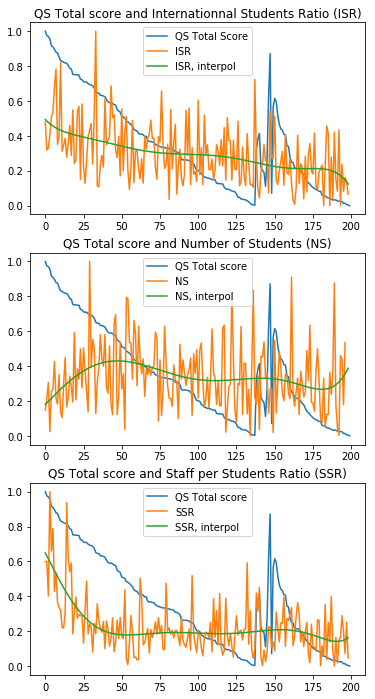

In [80]:
#feature 'International Student Ratio'
inter_students_ratio_norm_qs = normalise(merged_uni_rank['QS International Students Ratio'])
xp, polyfit_inter_student = interpole(inter_students_ratio_norm_qs, 7) #coeff

#feature 'Total students'
no_students_norm_qs = normalise(merged_uni_rank['QS No Students'])
xp, polyfit_no_student = interpole(no_students_norm_qs, 7) #coeff

#feature 'Staff per Student Ratio'
staff_students_ratio_norm_qs = normalise(merged_uni_rank['QS Staff per Student Ratio'])
xp, polyfit_staff_student = interpole(staff_students_ratio_norm_qs, 7) #coeff


#Display

plt.figure(figsize=(6,12))

plt.subplot(311)
plt.plot(ranking_norm_qs, label = 'QS Total Score')
plt.plot(inter_students_ratio_norm_qs, label='ISR')
plt.plot(xp, polyfit_inter_student(xp), label='ISR, interpol')
plt.title('QS Total score and Internationnal Students Ratio (ISR)')
plt.legend()

plt.subplot(312)
plt.plot(ranking_norm_qs,label = 'QS Total score')
plt.plot(no_students_norm_qs, label='NS') 
plt.plot(xp, polyfit_no_student(xp), label='NS, interpol')
plt.title('QS Total score and Number of Students (NS)')
plt.legend()

plt.subplot(313)
plt.plot(ranking_norm_qs,label = 'QS Total score')
plt.plot(staff_students_ratio_norm_qs, label='SSR')
plt.plot(xp, polyfit_staff_student(xp), label='SSR, interpol')
plt.title('QS Total score and Staff per Students Ratio (SSR)')
plt.legend()

We observe in above Figure three feature's tendency. 
- International Student Ratio seems to have a positive influence on universities' score.
- Number of students is pratically stable, execpt at ends where it seems it has a negative influence on universities' score.
- Staff per Students Ratio seems also to have positive influence on universities' score

#### THE Total Score
We normalise the THE score of the university

In [81]:
ranking_norm_THE = normalise(merged_uni_rank.sort_values(['THE Score'],ascending = False)['THE Score'])

#### THE features
As before, we normalise and interpolate all three THE features

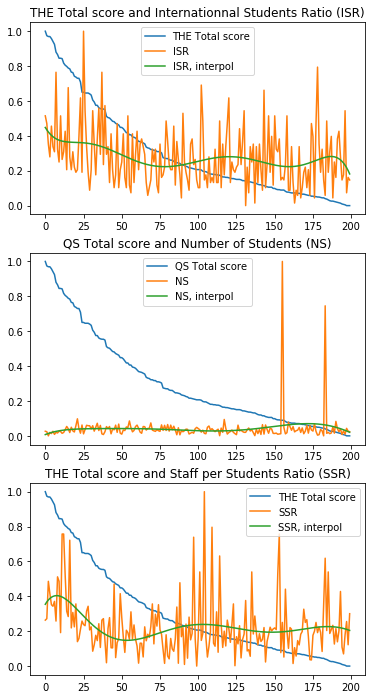

In [82]:
#feature 'International Student Ratio'
inter_student_norm_THE = normalise(merged_uni_rank.sort_values(['THE Score'],ascending = False)['THE International Students Ratio'])
xp, polyfit_inter_students_ratio = interpole(inter_student_norm_THE, 7) #coeff

#feature 'Total Students'
total_students_norm_THE = normalise(merged_uni_rank.sort_values(['THE Score'],ascending = False)['THE No Students'])
xp, polyfit_total_students = interpole(total_students_norm_THE, 7) #coeff

#feature 'Staff per Student Ratio'
staff_student_norm_THE = normalise(merged_uni_rank.sort_values(['THE Score'],ascending = False)['THE Staff per Student Ratio'])
xp, polyfit_staff_students_ratio = interpole(staff_student_norm_THE, 7) #coeff

#Display

plt.figure(figsize=(6,12))

plt.subplot(311)
plt.plot(ranking_norm_THE, label = 'THE Total score')
plt.plot(inter_student_norm_THE, label='ISR')
plt.plot(xp, polyfit_inter_students_ratio(xp), label='ISR, interpol')
plt.title('THE Total score and Internationnal Students Ratio (ISR)')
plt.legend()

plt.subplot(312)
plt.plot(ranking_norm_THE,label = 'QS Total score')
plt.plot(total_students_norm_THE, label='NS') 
plt.plot(xp, polyfit_total_students(xp), label='NS, interpol')
plt.title('QS Total score and Number of Students (NS)')
plt.legend()

plt.subplot(313)
plt.plot(ranking_norm_THE,label = 'THE Total score')
plt.plot(staff_student_norm_THE, label='SSR')
plt.plot(xp, polyfit_staff_students_ratio(xp), label='SSR, interpol')
plt.title('THE Total score and Staff per Students Ratio (SSR)')
plt.legend()


We observe in above Figure the three THE feature's tendency. 
- International Student Ratio seems to have a positive influence on universities' score.
- Number of students is pratically stable, except in two points. We consider them as outliers and will discard them since they do not give a good feedback on the global tendency.
- Staff per Students Ratio seems also to have positive influence on universities' score.  

We notice the features have approximatively the same behavior with respect to the rank in both ranking.

In [83]:
merged_uni_rank = merged_uni_rank.drop(['Scuola Superiore Sant\'Anna']).drop(['Scuola Normale Superiore di Pisa'])

## Display using Seaborn
Here we want to identify pairs of features that seems connected or inversely in conflict

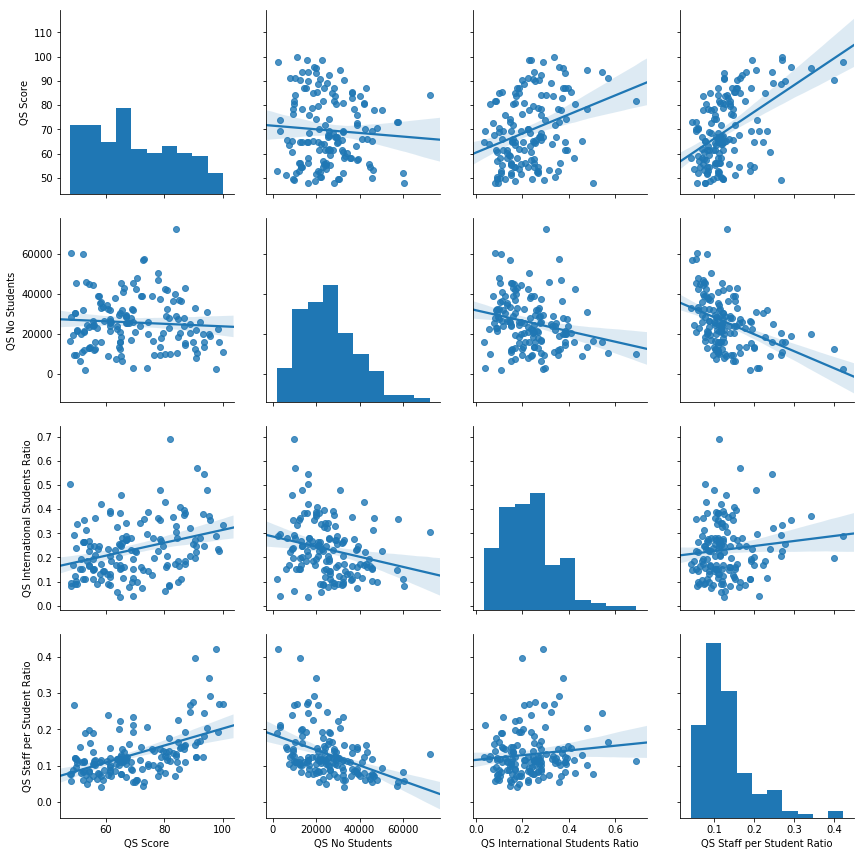

In [84]:
g1 = sns.pairplot(merged_uni_rank.dropna(), size=3, vars=['QS Score','QS No Students','QS International Students Ratio',\
                                                           'QS Staff per Student Ratio'], kind = "reg")

We have confirmation 'QS International Students Ratio' and 'QS Staff per Student Ratio' have both positive effect on the score of the university, therefore we see in plot[4,3] the linear regression has positive slope, meaning they migth be connected.  

On the other hand, we also have confirmation that 'Number of Student' has very limited effect on the ranking, see plot[2,1].

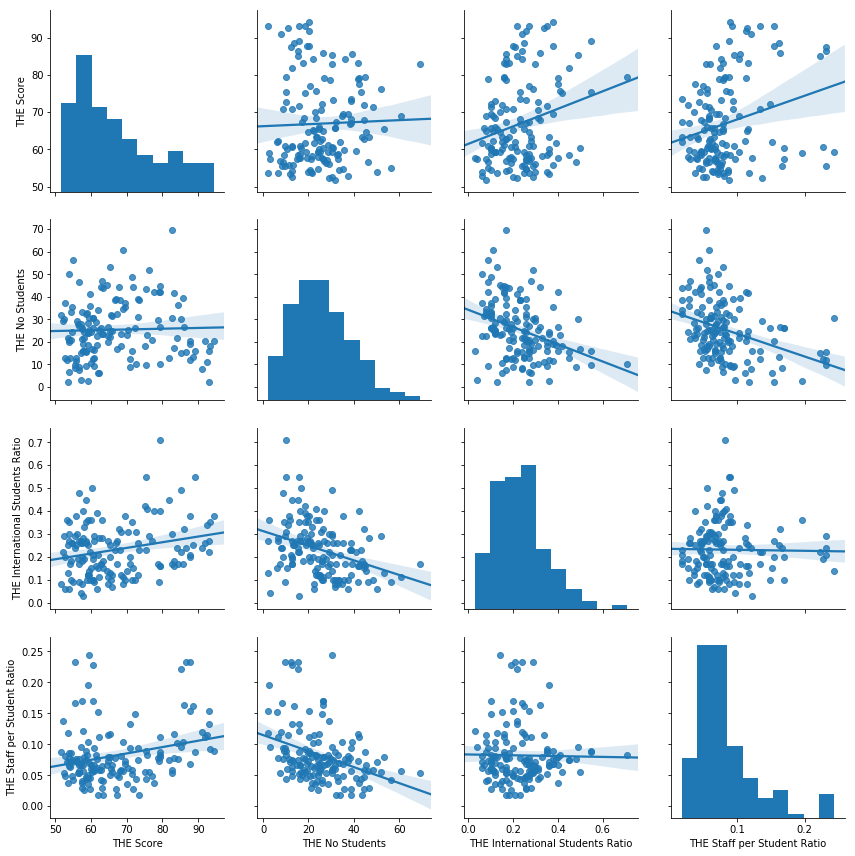

In [85]:
g2 = sns.pairplot(merged_uni_rank.dropna(), size=3, vars=['THE Score','THE No Students','THE International Students Ratio',\
                                'THE Staff per Student Ratio'], kind = "reg")

We see the same behaviors from the previous plot

## Strong Correlation

##### QS Pearson correlation

In [86]:
corr = merged_uni_rank.loc[:,['QS Score','QS No Students','QS International Students Ratio','QS Staff per Student Ratio']].corr(method = 'pearson')
corr

,QS Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio
QS Score,1.000000,-0.011294,0.388988,0.493537
QS No Students,-0.011294,1.000000,-0.180190,-0.313107
QS International Students Ratio,0.388988,-0.180190,1.000000,0.131621
QS Staff per Student Ratio,0.493537,-0.313107,0.131621,1.000000


The table above gives us numerical information about correlation between features.  

We are now able to quantify the connection between 'QS International Students Ratio' and 'QS Staff per Student Ratio', and attest there is no linear relationship between the 'QS Score' and 'QS No Students'.

Also, there is strong negative correlation between 'QS Staff per Student Ratio' and 'QS No Students'

##### THE Pearson correlation

In [87]:
corr = merged_uni_rank.dropna().loc[:,['THE Score','THE No Students','THE International Students Ratio','THE Staff per Student Ratio']].corr(method =  'pearson')
corr

,THE Score,THE No Students,THE International Students Ratio,THE Staff per Student Ratio
THE Score,1.000000,0.030310,0.241493,0.255372
THE No Students,0.030310,1.000000,-0.348954,-0.360370
THE International Students Ratio,0.241493,-0.348954,1.000000,-0.016763
THE Staff per Student Ratio,0.255372,-0.360370,-0.016763,1.000000


We take the same conclusions for THE ranking than the QS ranking.

# Question 5
In this part we will try to set up a ranking taking into account for both the THE and the QS ranking. To do so we will define a new score to rank the universities. 2 strategies will be investigated:
- Averaging the scores of the QS and of the THE rankings.
- Averaging the ranks of the QS and of the THE ranings.



In [88]:
merged_uni_rank.head()

,Location,Region,QS Rank,QS Score,THE Rank,THE Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio,QS Staff per Student Ratio.1,THE No Students,THE International Students Ratio,THE Staff per Student Ratio
Name,,,,,,,,,,,,,
Massachusetts Institute of Technology,United States,North America,1.0,100.0,5.0,92.5,11067.0,0.335863,0.269450,0.269450,11.177,0.34,0.114943
Stanford University,United States,North America,2.0,98.7,3.0,93.0,15878.0,0.227422,0.269870,0.269870,15.845,0.22,0.133333
Harvard University,United States,North America,3.0,98.4,6.0,91.8,22429.0,0.234785,0.193945,0.193945,20.326,0.26,0.112360
California Institute of Technology,United States,North America,4.0,97.7,3.0,93.0,2255.0,0.286918,0.422616,0.422616,2.209,0.27,0.153846
University of Cambridge,United Kingdom,Europe,5.0,95.6,2.0,93.2,18770.0,0.356899,0.292488,0.292488,18.389,0.35,0.091743


## First strategy, averaging the score
The first strategy that we are going to investigate is to average the score of both QS and THE rankings.

First we need to standardize the values of the QS and THE scores.

In [89]:
top_merged_uni_rank = merged_uni_rank.copy().dropna()
top_merged_uni_rank.shape

(148, 13)

In [90]:
top_merged_uni_rank['QS Score'] = normalise(top_merged_uni_rank['QS Score'])
top_merged_uni_rank['THE Score'] = normalise(top_merged_uni_rank['THE Score'])


In [91]:
top_merged_uni_rank.loc["University of Oxford"]

Location                            United Kingdom
Region                                      Europe
QS Rank                                          6
QS Score                                  0.909789
THE Rank                                         1
THE Score                                        1
QS No Students                               19720
QS International Students Ratio            0.37287
QS Staff per Student Ratio                0.342292
QS Staff per Student Ratio.1              0.342292
THE No Students                             20.409
THE International Students Ratio              0.38
THE Staff per Student Ratio              0.0892857
Name: University of Oxford, dtype: object

In [92]:
top_merged_uni_rank['Mean Score'] = top_merged_uni_rank[['QS Score', 'THE Score']].mean(axis=1)
#top_merged_uni_rank['Mean Score']
top_merged_uni_rank = top_merged_uni_rank.sort_values(['Mean Score'], ascending = False)
top_merged_uni_rank['New rank 1'] = np.array(range(1, top_merged_uni_rank.shape[0]+1))
top_merged_uni_rank.head()

,Location,Region,QS Rank,QS Score,THE Rank,THE Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio,QS Staff per Student Ratio.1,THE No Students,THE International Students Ratio,THE Staff per Student Ratio,Mean Score,New rank 1
Name,,,,,,,,,,,,,,,
Massachusetts Institute of Technology,United States,North America,1.0,1.000000,5.0,0.957746,11067.0,0.335863,0.269450,0.269450,11.177,0.34,0.114943,0.978873,1
Stanford University,United States,North America,2.0,0.975048,3.0,0.969484,15878.0,0.227422,0.269870,0.269870,15.845,0.22,0.133333,0.972266,2
California Institute of Technology,United States,North America,4.0,0.955854,3.0,0.969484,2255.0,0.286918,0.422616,0.422616,2.209,0.27,0.153846,0.962669,3
Harvard University,United States,North America,3.0,0.969290,6.0,0.941315,22429.0,0.234785,0.193945,0.193945,20.326,0.26,0.112360,0.955302,4
University of Oxford,United Kingdom,Europe,6.0,0.909789,1.0,1.000000,19720.0,0.372870,0.342292,0.342292,20.409,0.38,0.089286,0.954894,5


## Second strategy, averaging the rank
In this part we implement the second strategy where we rank the universities by averaging over their QS rank and THE rank.

In [93]:
top_merged_uni_rank['Mean Rank'] = top_merged_uni_rank[['QS Rank', 'THE Rank']].mean(axis=1)
#top_merged_uni_rank['Mean Score']
top_merged_uni_rank = top_merged_uni_rank.sort_values(['Mean Rank'], ascending = True)
top_merged_uni_rank['New rank 2'] = np.array(range(1, top_merged_uni_rank.shape[0]+1))
top_merged_uni_rank.head()

,Location,Region,QS Rank,QS Score,THE Rank,THE Score,QS No Students,QS International Students Ratio,QS Staff per Student Ratio,QS Staff per Student Ratio.1,THE No Students,THE International Students Ratio,THE Staff per Student Ratio,Mean Score,New rank 1,Mean Rank,New rank 2
Name,,,,,,,,,,,,,,,,,
Stanford University,United States,North America,2.0,0.975048,3.0,0.969484,15878.0,0.227422,0.269870,0.269870,15.845,0.22,0.133333,0.972266,2,2.5,1
Massachusetts Institute of Technology,United States,North America,1.0,1.000000,5.0,0.957746,11067.0,0.335863,0.269450,0.269450,11.177,0.34,0.114943,0.978873,1,3.0,2
California Institute of Technology,United States,North America,4.0,0.955854,3.0,0.969484,2255.0,0.286918,0.422616,0.422616,2.209,0.27,0.153846,0.962669,3,3.5,3
University of Oxford,United Kingdom,Europe,6.0,0.909789,1.0,1.000000,19720.0,0.372870,0.342292,0.342292,20.409,0.38,0.089286,0.954894,5,3.5,4
University of Cambridge,United Kingdom,Europe,5.0,0.915547,2.0,0.974178,18770.0,0.356899,0.292488,0.292488,18.389,0.35,0.091743,0.944863,6,3.5,5


We can remark that the first university have changed when ranking by averaging the QS and THE ranks. Indeed now it is Stanford that trusts the first place of the ranking instead of MIT. 

We can conclude that such rankings are very dependent on the way you define the ranking method. Indeed even slight modifications as we have investigated through strategy 1 and 2 can yield different results. We can therefore point out that the choice of the criterions used to rank the universities influences a lot the ranking. 